# **Projeto Volvo**

##Estimativa de valores de horímetro das máquinas da frota circulante

[Drive Volvo](https://drive.google.com/drive/folders/1HS80lS_XzGH7Tz9juk08d2IR65zZ4Cyv)

[Nosso Drive](https://drive.google.com/drive/folders/1QSw-csAJ1tW1FgAQQOY3tkXMBFcb2hmR?usp=sharing)


#0 - Informações sobre o projeto

###Projeto Volvo Construction Equipments na América Latina

####**Problema**
Dificuldade de obter dados da frota circulante, o que atrapalha a gestão e impacta o cliente

####**Perguntas**

1.   Como poderíamos inferir a partir de uma amostra da população de máquinas o valor de horímetro de um equipamento que não está comunicando através do dispositivo de telemetria?
2.   Seria possível estimar padrões de operação diária de um equipamento que não nos envia dados?


####**Solução**

Com base no histórico de dados, verificar se é possível prever padrões de operação diária de um equipamento (horímetro) que envia/não envia dados.


####**Objetivo**

Melhorar a gestão da frota circulante para que se alcance:

* o aumento da eficiência operacional da rede de distribuição
* a antecipação de necessidades dos clientes
* o aumento da produtividade das máquinas (uptime)
* a identificação de novas oportunidades em vendas de peças e serviços que não são exploradas
* o aumento de satisfação dos clientes Volvo CE

#1 - Hipóteses
*a serem testadas após o desenvolvimento do modelo preditivo*

* H0: É possível prever o horímetro da máquina com base no histórico de registros com precisão significativamente maior que a fornecida pelo cálculo atual (baseado em médias)
* H1: É possivel utilizar a mesma técnica para os 3 cenários de medição do problema?
1.   máquinas que enviaram dados nos últimos 4 dias
2.   máquinas que enviaram dados mas não recententemente
3.   máquinas que nunca enviaram dados
* H2: A técnica proposta garante resultados independentemente da classe da máquina: AHL; WL; EXC?
* H3: A técnica proposta garante resultados independentemente do segmento de aplicação da máquina?
* H4: A técnica proposta garante resultados independentemente do país onde a máquina está localizada?
* H5: A técnica proposta garante resultados independentemente do Dealer que realizou a venda?
* H6: A técnica proposta garante resultados independentemente da idade da máquina?

#2 - Dicionário

###**Variáveis**

**Dataset de equipamentos**

* Região: regiões de vendas. São 3 ('Hispânico Sul', 'Brasil', 'Hispânico Norte')

* País: onde a máquina foi comprada. São 3 ('Argentina', 'Brasil', 'México')

* Dealer: revendedor de peças. São 7 ('EPSA', 'Dinâmica', 'Gotemburgo', 'Linck', 'Tecnoeste', 'Tracbel', 'Ascendum')

* Segmento: atuação da máquina. São 5 ('Mining', 'Construction', 'Forestry', 'Agriculture', 'Industry')

* Modelo: linha da máquina WLO (Wheel Loader ou máquinas com pás articuladas), EXC (escavadeiras) e ART (caminhões articulados) ('ART', 'EXC', 'WLO')

* Chassis ID

* PIN17: identificação mais detalhada da máquina (não relevante para a análise)

* Delivery Date: data em que a máquina começou a trabalhar

* Obs.: observações internas da Volvo sobre a coleta de dados (não relevante para a análise)

* Estado: estado onde a máquina está operando atualmente ('San Luis', 'San Juan', 'Entre Ríos', 0, 'Jujuy','Provincia de Buenos Aires', 'Misiónes', 'Catamarca Province','Minas Gerais', 'Pará', 'Mato Grosso', 'Rondônia', 'Pernambuco','Bahia', 'Sergipe', 'Rio Grande do Norte', 'Paraná','Rio Grande do Sul', 'Santa Catarina', 'São Paulo','Mato Grosso do Sul', 'Rio de Janeiro', 'Veracruz','Estado de México', 'Nuevo León', 'Querétaro', 'Hidalgo','Coahuila de Zaragoza', 'Tabasco')

* Região: país onde a máquina está operando atualmente (pode diferir da de venda)

**Dataset de séries temporais**

* Chassis ID

* Machine History Date Day: dia no histórico de datas da máquina (dia de registro das horas)

* Compensated Working Hours By Day: quantidade de horas trabalhadas no dia

###**Outros**

Volvo CE: Volvo Construction Equipment

Horímetro: Quantidade de horas de operação que um equipamento tem

POC: proof of concept, a demonstration of a product in which work is focused on determining whether an idea can be turned into a reality

#3 - Importando bibliotecas

In [115]:
# Remover warnings
import warnings
warnings.filterwarnings('ignore')

In [116]:
import pandas_flavor as pf
import janitor

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
#from google.colab import drive
import matplotlib.pyplot as plt
from ipywidgets import interact
import statsmodels.api as sm

# bibliotecas para os modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# bibliotecas de métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#4 - Importando Dados

In [118]:
# importando o conjunto de dados
pd.set_option('display.max_columns', None)
#drive.mount('/content/drive')

equip = pd.read_excel('23w06_Equipamentos.xlsx')
temporal = pd.read_excel('23w06_SeriesTemporais_Horimetros.xlsx')

#5 - Analisando dados

In [119]:
# observando dataset equip
equip.head(2)

,Região,País,Dealer,Segmento,Modelo,Chassis ID,PIN17,Delivery Date,Obs.:,Estado,Região.1
0,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,VCEA040FCG0320538,2020-11-26,NaN,San Luis,Argentina
1,Hispânico Sul,Argentina,EPSA,Construction,ART,A30G732052,VCE0A30GCL0732052,2020-06-22,NaN,San Juan,Argentina


In [120]:
# observando informações básicas de equip
equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Região         63 non-null     object        
 1   País           63 non-null     object        
 2   Dealer         63 non-null     object        
 3   Segmento       63 non-null     object        
 4   Modelo         63 non-null     object        
 5   Chassis ID     63 non-null     object        
 6   PIN17          57 non-null     object        
 7   Delivery Date  62 non-null     datetime64[ns]
 8   Obs.:          15 non-null     object        
 9   Estado         63 non-null     object        
 10  Região.1       63 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.5+ KB


In [121]:
# verificando quantos valores nulos equip tem
equip.isna().sum()

Região            0
País              0
Dealer            0
Segmento          0
Modelo            0
Chassis ID        0
PIN17             6
Delivery Date     1
Obs.:            48
Estado            0
Região.1          0
dtype: int64

In [122]:
# identificando o índice do valor nulo de `Delivery Date`
indices_nulos = equip[equip['Delivery Date'].isnull()].index
print(indices_nulos)

Int64Index([22], dtype='int64')


In [123]:
# verificando qual ID está sem delivery date
print(equip.loc[22, 'Chassis ID'])

EC220240109


In [124]:
# removendo variáveis não relevantes e renomeando variáveis
equip = equip.drop(columns = ['Obs.:', 'PIN17'])
equip = equip.rename(columns={'Região.1': 'pais_operacao', 'País': 'pais_compra', 'Chassis ID': 'ID'})

In [125]:
# observando dataset temporal
temporal.head(2)

,Chassis Id*,Machine History Date Day,Compensated Working Hours By Day
0,A030F720057,2016-12-09,0.00
1,A030F720057,2016-12-10,5.75


In [126]:
# observando informações básicas de temporal
temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118161 entries, 0 to 118160
Data columns (total 3 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Chassis Id*                       118161 non-null  object        
 1   Machine History Date Day          118161 non-null  datetime64[ns]
 2   Compensated Working Hours By Day  118161 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.7+ MB


In [127]:
# verificando quantos valores nulos temporal tem
temporal.isna().sum()

Chassis Id*                         0
Machine History Date Day            0
Compensated Working Hours By Day    0
dtype: int64

In [128]:
# verificando quantos IDs temporal tem
len(temporal['Chassis Id*'].unique())

62

In [129]:
# verificando se o ID EC220240109 consta no dataset temporal
busca = temporal.loc[temporal['Chassis Id*'] == 'EC220240109'].index[0]
busca

38422

In [130]:
# verificando qual ID o equip tem a mais que temporal
chassis_temp = temporal['Chassis Id*'].unique()
chassis_equip = equip['ID'].unique()
valor_adicional = set(chassis_equip) - set(chassis_temp)

print(valor_adicional)

{'A30F720054'}


In [131]:
# renomeando variável
temporal = temporal.rename(columns={'Compensated Working Hours By Day': 'Horas', 'Machine History Date Day': 'Dia', 'Chassis Id*': 'ID'})

In [132]:
# removendo ID A30F720054
equip = equip.drop(equip[equip['ID'] == 'A30F720054'].index)

In [133]:
# observando os valores dos IDs no temporal
chassis_valores = temporal.groupby('ID').describe()
chassis_valores

Horas                                                           \
              count       mean       std  min        25%        50%      75%   
ID                                                                             
A030F720057  1805.0   6.851108  7.257318  0.0   0.000446   5.600000  12.4000   
A040F320538  2241.0   2.885249  5.186442  0.0   0.001818   0.004074   4.3000   
A040F320657  2121.0  14.792456  7.534622  0.0  10.700000  18.000000  20.4000   
A040F320672  2121.0   4.596603  5.129515  0.0   0.025926   3.750000   7.2500   
A30F072791   3041.0  11.465549  5.937882  0.0   8.950000  12.500000  16.4000   
...             ...        ...       ...  ...        ...        ...      ...   
L60F073972    921.0  14.318868  6.292234  0.0  11.550000  15.450000  18.5500   
L60F074089    916.0   4.702040  4.962446  0.0   0.091071   3.000000   8.7000   
L60F074104    897.0   4.625585  3.941112  0.0   0.000000   4.900000   7.4500   
L60F074121    891.0   3.062028  2.995701  0.0   1.400000   2.700000   4.2500   
L60F074213    808.0   6.495359  5.074819  0.0   1.187500   6.325000   9.5625   

                    
               max  
ID                  
A030F720057  57.20  
A040F320538  22.10  
A040F320657  29.40  
A040F320672  23.85  
A30F072791   35.35  
...            ...  
L60F073972   32.50  
L60F074089   28.55  
L60F074104   21.35  
L60F074121   56.35  
L60F074213   26.50  

[62 rows x 8 columns]

In [134]:
# juntando os dois datasets para visualizar
df_original = equip.merge(temporal, how = 'left', left_on = 'ID', right_on = 'ID')

In [135]:
df = df_original.copy()

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118161 entries, 0 to 118160
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Região         118161 non-null  object        
 1   pais_compra    118161 non-null  object        
 2   Dealer         118161 non-null  object        
 3   Segmento       118161 non-null  object        
 4   Modelo         118161 non-null  object        
 5   ID             118161 non-null  object        
 6   Delivery Date  115120 non-null  datetime64[ns]
 7   Estado         118161 non-null  object        
 8   pais_operacao  118161 non-null  object        
 9   Dia            118161 non-null  datetime64[ns]
 10  Horas          118161 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 10.8+ MB


In [137]:
# criando gráficos
@interact(id = temporal.ID.unique().tolist())
def graficos(id):
    plt.figure(figsize= (16,3))
    ax = sns.lineplot(data = temporal[temporal.ID == id],
                      x = 'Dia',
                      y = 'Horas')
    plt.show()

interactive(children=(Dropdown(description='id', options=('A030F720057', 'A040F320538', 'A040F320657', 'A040F3…

In [138]:
# criando variável para armazenar as variáveis que vão ser apresentadas na tabela geral
cols = ['Região', 'País Compra','Dealer','Segmento','Modelo','Estado','País Operação', 'ID']

In [139]:
# criando tabela geral para visualizar os principais dados das principais variáveis
@interact(agg_fun = ['sum', 'mean','max'], col_groupby = cols)


def tabela_geral(agg_fun,col_groupby):
    df2 = df.groupby([col_groupby], sort = 'Horas')[['Horas']].agg(agg_fun)\
              .sort_values('Horas', ascending = False)

    return df2.style.highlight_min(color = 'black')\
                    .highlight_max(color = 'lightcoral')

interactive(children=(Dropdown(description='agg_fun', options=('sum', 'mean', 'max'), value='sum'), Dropdown(d…

#6 - Criando novas variáveis


### 6.1 - Método 1: Aplicando One Hot Encoding nas variáveis categóricas

In [140]:
#criando df2 para o Método 2
df2 = df

In [141]:
# aplicando One Hot Encoding às variáveis
df_aux = pd.get_dummies(df['Segmento'], prefix='Segmento')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Modelo'], prefix='Modelo')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Dealer'], prefix='Dealer')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Região'], prefix='Região')
df = pd.concat([df, df_aux], axis=1)

In [142]:
# deletando variáveis originais
df.drop(['Segmento', 'Modelo', 'Dealer', 'Região'], axis=1, inplace=True)

In [143]:
# apagando os dados vazios
df = df.dropna()

In [144]:
df.head(2)

,pais_compra,ID,Delivery Date,Estado,pais_operacao,Dia,Horas,Segmento_Agriculture,Segmento_Construction,Segmento_Forestry,Segmento_Industry,Segmento_Mining,Modelo_ART,Modelo_EXC,Modelo_WLO,Dealer_Ascendum,Dealer_Dinâmica,Dealer_EPSA,Dealer_Gotemburgo,Dealer_Linck,Dealer_Tecnoeste,Dealer_Tracbel,Região_Brasil,Região_Hispânico Norte,Região_Hispânico Sul
0,Argentina,A040F320538,2020-11-26,San Luis,Argentina,2016-12-14,0.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1
1,Argentina,A040F320538,2020-11-26,San Luis,Argentina,2016-12-15,0.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1


### 6.2 - Método 2: Adicionando médias dos horimetros

In [145]:
dayOfWeek={0:'Seg', 1:'Ter', 2:'Qua', 3:'Qui', 4:'Sex', 5:'Sab', 6:'Dom'}
df2['dia_da_semana'] = df2.Dia.dt.dayofweek.map(dayOfWeek)
df2["mes"] = df2.Dia.dt.month

In [146]:
df2.groupby(['Modelo',"pais_operacao","dia_da_semana"])[["Horas"]].mean().reset_index()

,Modelo,pais_operacao,dia_da_semana,Horas
0,ART,Argentina,Dom,2.076216
1,ART,Argentina,Qua,7.280186
2,ART,Argentina,Qui,6.990743
3,ART,Argentina,Sab,4.979574
4,ART,Argentina,Seg,4.885679
...,...,...,...,...
135,WLO,Sul,Qui,7.747734
136,WLO,Sul,Sab,3.954848
137,WLO,Sul,Seg,7.424557
138,WLO,Sul,Sex,7.789480


In [147]:
df2.groupby(['ID',"dia_da_semana"])[["Horas"]].mean().reset_index()

,ID,dia_da_semana,Horas
0,A030F720057,Dom,1.400040
1,A030F720057,Qua,9.219244
2,A030F720057,Qui,9.591219
3,A030F720057,Sab,4.725538
4,A030F720057,Seg,6.170583
...,...,...,...
429,L60F074213,Qui,8.481739
430,L60F074213,Sab,5.934783
431,L60F074213,Seg,5.556897
432,L60F074213,Sex,8.137391


In [148]:
# Seleciona as colunas para o loop for
cols = ["Região","Dealer","Segmento","Modelo"]

# Coluna que será feito o calculo
agg = ["Horas"]

# Métricas
func = ['mean',"min","max",'median']

In [149]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = [col,"dia_da_semana","ID",],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

In [150]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = ["ID", col, "dia_da_semana"],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

In [151]:
# verificando as correções, porém com o gráfica fica pouca visualização
#sns.heatmap(df2.corr(), annot=True);

In [152]:
# apagando os dados vazios
df2 = df2.dropna()

In [153]:
df2.head(2)

,Região,pais_compra,Dealer,Segmento,Modelo,ID,Delivery Date,Estado,pais_operacao,Dia,Horas,dia_da_semana,mes,Região_mean_Horas,Região_min_Horas,Região_max_Horas,Região_median_Horas,Dealer_mean_Horas,Dealer_min_Horas,Dealer_max_Horas,Dealer_median_Horas,Segmento_mean_Horas,Segmento_min_Horas,Segmento_max_Horas,Segmento_median_Horas,Modelo_mean_Horas,Modelo_min_Horas,Modelo_max_Horas,Modelo_median_Horas
0,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,2020-11-26,San Luis,Argentina,2016-12-14,0.0,Qua,12,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167
1,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,2020-11-26,San Luis,Argentina,2016-12-15,0.0,Qui,12,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545


# **7 - Ajustando e Separando Dados (Treino e Teste)**

### 7.1 - Método 1

In [154]:
# apagando as variaveis categoricas e ficando apenas as numericas PARA O MODELO 1
df.drop(['pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia'], axis=1, inplace=True)

In [155]:
# criando X e y
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [156]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115120 entries, 0 to 118160
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Segmento_Agriculture    115120 non-null  uint8
 1   Segmento_Construction   115120 non-null  uint8
 2   Segmento_Forestry       115120 non-null  uint8
 3   Segmento_Industry       115120 non-null  uint8
 4   Segmento_Mining         115120 non-null  uint8
 5   Modelo_ART              115120 non-null  uint8
 6   Modelo_EXC              115120 non-null  uint8
 7   Modelo_WLO              115120 non-null  uint8
 8   Dealer_Ascendum         115120 non-null  uint8
 9   Dealer_Dinâmica         115120 non-null  uint8
 10  Dealer_EPSA             115120 non-null  uint8
 11  Dealer_Gotemburgo       115120 non-null  uint8
 12  Dealer_Linck            115120 non-null  uint8
 13  Dealer_Tecnoeste        115120 non-null  uint8
 14  Dealer_Tracbel          115120 non-null  uint8
 15  

### 7.2 - Método 2

In [157]:
# apagando as variaveis categoricas e ficando apenas as numericas
df2.drop(['Região','Dealer','Segmento','Modelo','pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia',"dia_da_semana","mes"], axis=1, inplace=True)

In [158]:
# criando X e y
X = df2.iloc[:, 1:]
y = df2.iloc[:, 0]

### 7.3 Treinando os modelos

In [159]:
# separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **8 - Aplicando Modelos**


### 8.1 - Regressão Linear

In [160]:
# criando modelo de Regressão Linear
modeloLR = LinearRegression()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloLR.fit(X_train, y_train)

LinearRegression()

### 8.2 - Random Forest

In [161]:
# criando modelo Random Forest
modeloRF = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2)

### 8.3 - Random Forest (alterando parâmetros)

In [162]:
# tunando modelo Random Forest
modeloRF2 = RandomForestRegressor(n_estimators=200, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF2.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200)

### 8.4 - Regressão Lasso

In [163]:
# criando modelo de Lasso
modeloRL = Lasso()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRL.fit(X_train, y_train)

Lasso()

### 8.5 - Regressão de cume (Ridge)

In [164]:
# criando modelo de Cume
modeloRC = Ridge()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC.fit(X_train, y_train)

Ridge()

### 8.6 - Regressão de cume (Ridge)2

In [165]:
# criando modelo de Cume
modeloRC2 = Ridge(alpha=0, random_state=42)

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC2.fit(X_train, y_train)

Ridge(alpha=0, random_state=42)

### 8.6 - Regressão XGBoost

In [166]:
# criando modelo de Regressão XGBoost
modeloXGB = XGBRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 8.7 - Regressão XGBoost2 (alterando parâmetros)

In [167]:
# tunando modelo de Regressão XGBoost
modeloXGB2 = XGBRegressor(n_estimators=2000, max_depth=8)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 8.8 - Decision Tree Regressor

In [168]:
# criando modelo
modeloDT = DecisionTreeRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloDT.fit(X_train, y_train)

DecisionTreeRegressor()

### 8.9 - KNN Regressor

In [169]:
# criando modelo KNN Regressor
modeloKNN = KNeighborsRegressor(n_neighbors=5) # considerando 5 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN.fit(X_train, y_train)

KNeighborsRegressor()

### 8.10 - KNN Regressor (alterando parâmetros)

In [170]:
# criando modelo KNN Regressor
modeloKNN2 = KNeighborsRegressor(n_neighbors=6) # considerando 6 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

### 8.11 - LSTM (Long Short-Term Memory)

In [171]:
# 1. Importando bibliotecas necessárias
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU

from keras.callbacks import EarlyStopping

# Define o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [172]:
# 2. Preparando dados
# Normalizar os dados pode ser uma boa prática ao trabalhar com redes neurais
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [173]:
# 3. Construir o modelo
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=70, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model_LSTM.add(LSTM(units=70))
model_LSTM.add(Dense(units=1))

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
model_LSTM.fit(X_train_scaled, y_train, epochs=100, batch_size=128, validation_split=0.10, callbacks=[early_stopping])


Epoch 1/100
567/567 [==============================] - 7s 7ms/step - loss: 27.7181 - val_loss: 23.8030
Epoch 2/100
567/567 [==============================] - 3s 6ms/step - loss: 25.7554 - val_loss: 25.0317
Epoch 3/100
567/567 [==============================] - 3s 6ms/step - loss: 25.7710 - val_loss: 23.8662
Epoch 4/100
567/567 [==============================] - 3s 6ms/step - loss: 25.7630 - val_loss: 23.8099
Epoch 5/100
567/567 [==============================] - 3s 6ms/step - loss: 25.6927 - val_loss: 23.8440
Epoch 6/100
567/567 [==============================] - 3s 6ms/step - loss: 25.6728 - val_loss: 23.9707


In [174]:
# 5. Fazer previsões
predicted_values = model_LSTM.predict(X_test_scaled)

1080/1080 [==============================] - 3s 2ms/step


### 8.12 - BDLSTM (Bidirecional Long Short-Term Memory)

In [175]:
# 3. Construir o modelo
model_BDLSTM = Sequential()
model_BDLSTM.add(Bidirectional(LSTM(units=70, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)))
model_BDLSTM.add(Bidirectional(LSTM(units=70)))
model_BDLSTM.add(Dense(units=1))

model_BDLSTM.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
history = model_BDLSTM.fit(X_train_scaled, y_train, epochs=100, batch_size=256, validation_split=0.10, callbacks=[early_stopping])

Epoch 1/100
284/284 [==============================] - 9s 13ms/step - loss: 28.3223 - val_loss: 23.7997
Epoch 2/100
284/284 [==============================] - 3s 9ms/step - loss: 25.7347 - val_loss: 24.1327
Epoch 3/100
284/284 [==============================] - 3s 9ms/step - loss: 25.6220 - val_loss: 23.7076
Epoch 4/100
284/284 [==============================] - 3s 9ms/step - loss: 25.6884 - val_loss: 23.9598
Epoch 5/100
284/284 [==============================] - 3s 9ms/step - loss: 25.5727 - val_loss: 23.6982
Epoch 6/100
284/284 [==============================] - 3s 9ms/step - loss: 25.4858 - val_loss: 23.6863
Epoch 7/100
284/284 [==============================] - 3s 9ms/step - loss: 25.2693 - val_loss: 23.1917
Epoch 8/100
284/284 [==============================] - 3s 9ms/step - loss: 25.0712 - val_loss: 23.3800
Epoch 9/100
284/284 [==============================] - 3s 9ms/step - loss: 25.0450 - val_loss: 23.1147
Epoch 10/100
284/284 [==============================] - 3s 9ms/step - lo

In [176]:
# 5. Fazer previsões
predicted_values_BDLSTM = model_BDLSTM.predict(X_test_scaled)

1080/1080 [==============================] - 5s 3ms/step


### 8.13 - GRU

In [177]:
# 3. Construir o modelo GRU
model_GRU = Sequential()
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dense(units=1))

model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
history = model_GRU.fit(X_train_scaled, y_train, epochs=100, batch_size=256, validation_split=0.10, callbacks=[early_stopping])

Epoch 1/100
284/284 [==============================] - 5s 8ms/step - loss: 35.0046 - val_loss: 25.1179
Epoch 2/100
284/284 [==============================] - 2s 6ms/step - loss: 26.3711 - val_loss: 24.1372
Epoch 3/100
284/284 [==============================] - 2s 6ms/step - loss: 25.3512 - val_loss: 23.2112
Epoch 4/100
284/284 [==============================] - 2s 6ms/step - loss: 24.9585 - val_loss: 23.0301
Epoch 5/100
284/284 [==============================] - 2s 6ms/step - loss: 24.8879 - val_loss: 22.9865
Epoch 6/100
284/284 [==============================] - 2s 6ms/step - loss: 24.8678 - val_loss: 22.9888
Epoch 7/100
284/284 [==============================] - 2s 6ms/step - loss: 24.8541 - val_loss: 22.9938
Epoch 8/100
284/284 [==============================] - 2s 6ms/step - loss: 24.8612 - val_loss: 23.1052
Epoch 9/100
284/284 [==============================] - 2s 6ms/step - loss: 24.8357 - val_loss: 22.9510
Epoch 10/100
284/284 [==============================] - 2s 6ms/step - los

In [178]:
# 5. Fazer previsões
predicted_values_GRU_last = model_GRU.predict(X_test_scaled)
# Supondo que predicted_values_GRU tenha a forma (n_samples, sequence_length, n_features)
# Pegue apenas o último output da sequência para cada amostra
predicted_values_GRU = predicted_values_GRU_last[:, -1, :]

1080/1080 [==============================] - 4s 3ms/step


### 8.14 - Bidirecional GRU

In [179]:
# 3. Construir o modelo GRU
model_BGRU = Sequential()
model_BGRU.add(Bidirectional(GRU(units=50, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)))
model_BGRU.add(Bidirectional(GRU(units=50, return_sequences=True)))
model_BGRU.add(Dense(units=1))

model_BGRU.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
history = model_BGRU.fit(X_train_scaled, y_train, epochs=100, batch_size=256, validation_split=0.10, callbacks=[early_stopping])

Epoch 1/100
284/284 [==============================] - 9s 13ms/step - loss: 30.0521 - val_loss: 23.9453
Epoch 2/100
284/284 [==============================] - 2s 9ms/step - loss: 25.8109 - val_loss: 23.8656
Epoch 3/100
284/284 [==============================] - 3s 9ms/step - loss: 25.7213 - val_loss: 23.8337
Epoch 4/100
284/284 [==============================] - 3s 9ms/step - loss: 25.7098 - val_loss: 23.8135
Epoch 5/100
284/284 [==============================] - 3s 9ms/step - loss: 25.6732 - val_loss: 23.7691
Epoch 6/100
284/284 [==============================] - 2s 9ms/step - loss: 25.5915 - val_loss: 23.7803
Epoch 7/100
284/284 [==============================] - 3s 9ms/step - loss: 25.4597 - val_loss: 23.5317
Epoch 8/100
284/284 [==============================] - 3s 9ms/step - loss: 25.2686 - val_loss: 23.3310
Epoch 9/100
284/284 [==============================] - 3s 9ms/step - loss: 25.1401 - val_loss: 23.0864
Epoch 10/100
284/284 [==============================] - 3s 9ms/step - lo

In [180]:
# 5. Fazer previsões
predicted_values_BGRU_last = model_BGRU.predict(X_test_scaled)
# Supondo que predicted_values_GRU tenha a forma (n_samples, sequence_length, n_features)
# Pegue apenas o último output da sequência para cada amostra
predicted_values_BGRU = predicted_values_BGRU_last[:, -1, :]

1080/1080 [==============================] - 5s 4ms/step


# **9 - Comparando Modelos**

### 9.1 - Método 1

In [181]:
# Função para calcular o MAE - Método 1
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo1 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo1)
Erro_absoluto_RF_modelo1 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo1)
Erro_absoluto_RF2_modelo1 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo1)
Erro_absoluto_RL_modelo1 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo1)
Erro_absoluto_RC_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo1)
Erro_absoluto_RC2_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo1)
Erro_absoluto_XGB_modelo1 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo1)
Erro_absoluto_XGB2_modelo1 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo1)
Erro_absoluto_DT_modelo1 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo1)
Erro_absoluto_KNN_modelo1 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo1)
Erro_absoluto_KNN2_modelo1 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo1)

Erro_absoluto_model_LSTM = mean_absolute_error(predicted_values, y_test)
print('LSTM:', Erro_absoluto_model_LSTM)

Erro_absoluto_model_BDLSTM = mean_absolute_error(predicted_values_BDLSTM, y_test)
print('BDLSTM:', Erro_absoluto_model_BDLSTM)

Erro_absoluto_model_GRU = mean_absolute_error(predicted_values_GRU, y_test)
print('GRU:', Erro_absoluto_model_GRU)

Erro_absoluto_model_BGRU = mean_absolute_error(predicted_values_BGRU, y_test)
print('BGRU:', Erro_absoluto_model_BGRU)

Regressão Linear: 3.56709482127068
Random Forest: 3.582497469652593
Random Forest2: 3.5824129831262654
Regressão de Laço: 3.6224855890794347
Regressão de Cume: 3.567094837308428
Regressão de Cume2: 3.567094837308428
XGBoost: 3.5818566035237036
XGBoost2: 3.5820960235944224
Decision Tree: 3.5821924527680244
KNN: 3.8664215199012446
KNN2: 3.795736260505864
LSTM: 3.6429943578961255
BDLSTM: 3.578592561484765
GRU: 3.5675688722063787
BGRU: 3.5523998070640364


In [182]:
# Função para calcular e imprimir MSE e RMSE - Método 1
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')

def calcular_e_imprimir_mse_rmse_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)

    # Se a previsão tiver 3 dimensões, pegue apenas o último output da sequência para cada amostra
    if predicoes.ndim == 3:
        predicoes = predicoes[:, -1, :]

    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)

    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Usando a função
calcular_e_imprimir_mse_rmse_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_BDLSTM, "Modelo Keras Bidirecional LSTM", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_GRU, "Modelo Keras GRU", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_BGRU, "Modelo Keras Bidirecional GRU", X_test_scaled)


MSE do Regressão Linear: 25.185476259227435
RMSE do Regressão Linear: 5.018513351504351

MSE do Random Forest: 25.427444002645338
RMSE do Random Forest: 5.042563237347187

MSE do Random Forest2: 25.423218588342817
RMSE do Random Forest2: 5.04214424509482

MSE do Regressão de Lasso: 25.29347152004985
RMSE do Regressão de Lasso: 5.0292615283011335

MSE do Regressão de Cume: 25.18547637147219
RMSE do Regressão de Cume: 5.018513362687419

MSE do Regressão de Cume2: 26.30855253991143
RMSE do Regressão de Cume2: 5.129186342872662

MSE do XGBoost: 25.41934648699767
RMSE do XGBoost: 5.041760256795008

MSE do XGBoost2: 25.42214486004429
RMSE do XGBoost2: 5.042037768605496

MSE do Decision Tree: 25.42325388035038
RMSE do Decision Tree: 5.0421477447958996

MSE do KNN: 30.666202867701926
RMSE do KNN: 5.537707365661527

MSE do KNN2: 29.522315575098503
RMSE do KNN2: 5.433444172447022
1080/1080 [==============================] - 3s 2ms/step

MSE do Modelo Keras LSTM: 25.96962413702699
RMSE do Modelo

In [183]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

def calcular_e_imprimir_r2_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)

    # Se a previsão tiver 3 dimensões, pegue apenas o último output da sequência para cada amostra
    if predicoes.ndim == 3:
        predicoes = predicoes[:, -1, :]

    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Usando a função
calcular_e_imprimir_r2_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_r2_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)
calcular_e_imprimir_r2_keras(model_GRU, "Modelo Keras GRU", X_test_scaled)
calcular_e_imprimir_r2_keras(model_BGRU, "Modelo Keras Bidirecional GRU", X_test_scaled)


R² do Regressão Linear: 0.3928648741338798
R² do Random Forest: 0.38703186486919516
R² do Random Forest2: 0.3871337250610769
R² do Regressão de Lasso: 0.39026148019375784
R² do Regressão de Cume: 0.39286487142804516
R² do Regressão de Cume2: 0.365791371452726
R² do XGBoost: 0.3872270680939167
R² do XGBoost2: 0.38715960895379986
R² do Decision Tree: 0.3871328742922754
R² do KNN: 0.26074342425441566
R² do KNN2: 0.2883186087862939
1080/1080 [==============================] - 3s 3ms/step
R² do Modelo Keras LSTM: 0.37396176840797335
1080/1080 [==============================] - 4s 4ms/step
R² do Modelo Keras Bidirecional: 0.39176615950507176
1080/1080 [==============================] - 3s 3ms/step
R² do Modelo Keras GRU: 0.3921098297944864
1080/1080 [==============================] - 4s 4ms/step
R² do Modelo Keras Bidirecional GRU: 0.39129204760849134


In [111]:
resultados_1 = pd.DataFrame([Erro_absoluto_LR_modelo1,
                           Erro_absoluto_RF_modelo1,
                           Erro_absoluto_RF2_modelo1,
                           Erro_absoluto_RL_modelo1,
                           Erro_absoluto_RC_modelo1,
                           Erro_absoluto_RC2_modelo1,
                           Erro_absoluto_XGB_modelo1,
                           Erro_absoluto_XGB2_modelo1,
                           Erro_absoluto_DT_modelo1,
                           Erro_absoluto_KNN_modelo1,
                           Erro_absoluto_KNN2_modelo1,
                           Erro_absoluto_model_LSTM,
                           Erro_absoluto_model_BDLSTM,
                              Erro_absoluto_model_GRU,
                              Erro_absoluto_model_BGRU])


resultados_1["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2",
                         "LSTM",
                         "BDLSTM",
                           'GRU',
                           'BGRU']

resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [112]:
resultados_1["metodo"] = 1

In [113]:
resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [114]:
resultados_1

,erro_medio,modelos,metodo
0,4.881213,Reg. Linear,1
1,4.065858,R. Forest,1
2,4.066342,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066162,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


### 9.2 - Método 2

In [184]:
# Função para calcular o MAE - Método 2
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo2 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo2)
Erro_absoluto_RF_modelo2 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo2)
Erro_absoluto_RF2_modelo2 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo2)
Erro_absoluto_RL_modelo2 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo2)
Erro_absoluto_RC_modelo2 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo2)
Erro_absoluto_RC2_modelo2 = calcular_mae(modeloRC2)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo2)
Erro_absoluto_XGB_modelo2 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo2)
Erro_absoluto_XGB2_modelo2 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo2)
Erro_absoluto_DT_modelo2 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo2)
Erro_absoluto_KNN_modelo2 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo2)
Erro_absoluto_KNN2_modelo2 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo2)

Erro_absoluto_model_LSTM_modelo2 = mean_absolute_error(predicted_values, y_test)
print('LSTM:', Erro_absoluto_model_LSTM_modelo2)

Erro_absoluto_model_BDLSTM_modelo2 = mean_absolute_error(predicted_values_BDLSTM, y_test)
print('BDLSTM:', Erro_absoluto_model_BDLSTM_modelo2)

Erro_absoluto_model_GRU_modelo2 = mean_absolute_error(predicted_values_GRU, y_test)
print('LSTM:', Erro_absoluto_model_GRU_modelo2)

Erro_absoluto_model_BGRU_modelo2 = mean_absolute_error(predicted_values_BGRU, y_test)
print('BDLSTM:', Erro_absoluto_model_BGRU_modelo2)

Regressão Linear: 3.56709482127068
Random Forest: 3.582497469652593
Random Forest2: 3.5824129831262654
Regressão de Laço: 3.6224855890794347
Regressão de Cume: 3.567094837308428
Regressão de Cume2: 3.864257319608739
XGBoost: 3.5818566035237036
XGBoost2: 3.5820960235944224
Decision Tree: 3.5821924527680244
KNN: 3.8664215199012446
KNN2: 3.795736260505864
LSTM: 3.6429943578961255
BDLSTM: 3.578592561484765
LSTM: 3.5675688722063787
BDLSTM: 3.5523998070640364


In [185]:
# Função para calcular e imprimir MSE e RMSE - Método 2
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')

def calcular_e_imprimir_mse_rmse_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)

    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)

    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Usando a função
calcular_e_imprimir_mse_rmse_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)


MSE do Regressão Linear: 25.185476259227435
RMSE do Regressão Linear: 5.018513351504351

MSE do Random Forest: 25.427444002645338
RMSE do Random Forest: 5.042563237347187

MSE do Random Forest2: 25.423218588342817
RMSE do Random Forest2: 5.04214424509482

MSE do Regressão de Lasso: 25.29347152004985
RMSE do Regressão de Lasso: 5.0292615283011335

MSE do Regressão de Cume: 25.18547637147219
RMSE do Regressão de Cume: 5.018513362687419

MSE do Regressão de Cume2: 26.30855253991143
RMSE do Regressão de Cume2: 5.129186342872662

MSE do XGBoost: 25.41934648699767
RMSE do XGBoost: 5.041760256795008

MSE do XGBoost2: 25.42214486004429
RMSE do XGBoost2: 5.042037768605496

MSE do Decision Tree: 25.42325388035038
RMSE do Decision Tree: 5.0421477447958996

MSE do KNN: 30.666202867701926
RMSE do KNN: 5.537707365661527

MSE do KNN2: 29.522315575098503
RMSE do KNN2: 5.433444172447022
1080/1080 [==============================] - 3s 3ms/step

MSE do Modelo Keras LSTM: 25.96962413702699
RMSE do Modelo

In [186]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

def calcular_e_imprimir_r2_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)

    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Usando a função
calcular_e_imprimir_r2_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_r2_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)

R² do Regressão Linear: 0.3928648741338798
R² do Random Forest: 0.38703186486919516
R² do Random Forest2: 0.3871337250610769
R² do Regressão de Lasso: 0.39026148019375784
R² do Regressão de Cume: 0.39286487142804516
R² do XGBoost: 0.3872270680939167
R² do XGBoost2: 0.38715960895379986
R² do Decision Tree: 0.3871328742922754
R² do KNN: 0.26074342425441566
R² do KNN2: 0.2883186087862939
1080/1080 [==============================] - 3s 2ms/step
R² do Modelo Keras LSTM: 0.37396176840797335
1080/1080 [==============================] - 4s 3ms/step
R² do Modelo Keras Bidirecional: 0.39176615950507176


In [187]:
resultados_2 = pd.DataFrame([Erro_absoluto_LR_modelo2,
                           Erro_absoluto_RF_modelo2,
                           Erro_absoluto_RF2_modelo2,
                           Erro_absoluto_RL_modelo2,
                           Erro_absoluto_RC_modelo2,
                           Erro_absoluto_RC2_modelo2,
                           Erro_absoluto_XGB_modelo2,
                           Erro_absoluto_XGB2_modelo2,
                           Erro_absoluto_DT_modelo2,
                           Erro_absoluto_KNN_modelo2,
                           Erro_absoluto_KNN2_modelo2,
                           Erro_absoluto_model_LSTM_modelo2,
                           Erro_absoluto_model_BDLSTM_modelo2,
                             Erro_absoluto_model_GRU_modelo2,
                             Erro_absoluto_model_BGRU_modelo2])

resultados_2["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2",
                         "LSTM",
                         "BDLSTM",
                           'GRU',
                           'BGRU']

In [188]:
resultados_2["metodo"] = 2

In [189]:
resultados_2 = resultados_2.rename({0: "erro_medio"}, axis = 1)

In [190]:
resultados_2

,erro_medio,modelos,metodo
0,3.567095,Reg. Linear,2
1,3.582497,R. Forest,2
2,3.582413,R. Forest2,2
3,3.622486,Reg. Lasso,2
4,3.567095,Reg. Cume,2
5,3.864257,Reg. Cume2,2
6,3.581857,XGBoost,2
7,3.582096,XGBoost2,2
8,3.582192,Decision Tree,2
9,3.866422,KNN,2


#10 - Comparando Métodos

In [191]:
metricas = pd.concat([resultados_1,resultados_2])

In [192]:
metricas

,erro_medio,modelos,metodo
0,4.881213,Reg. Linear,1
1,4.065858,R. Forest,1
2,4.066342,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066162,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


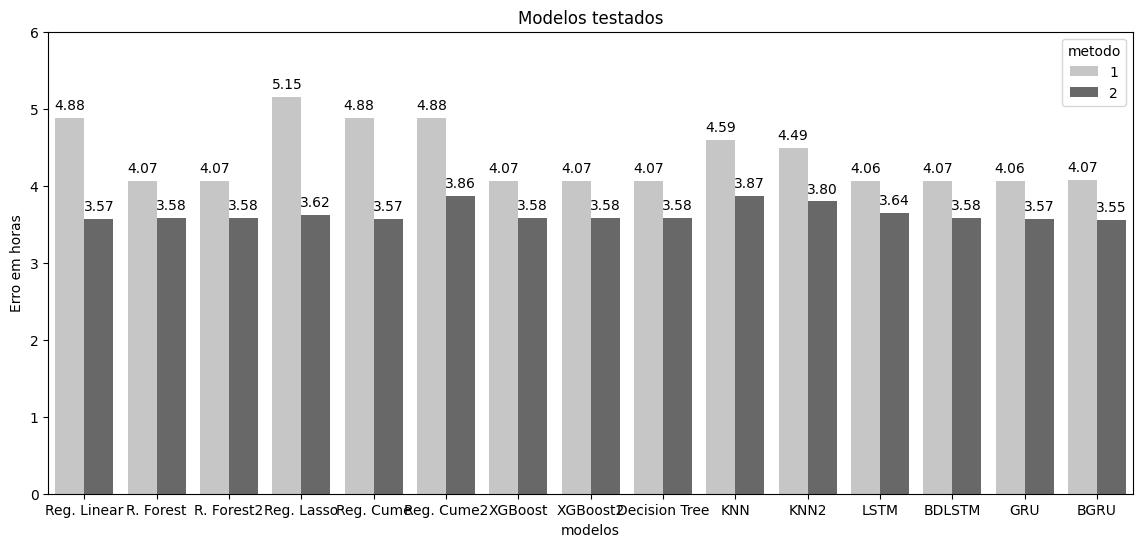

In [193]:
plt.figure(figsize = (14,6))

splot = sns.barplot(data= metricas,
            x = "modelos",
            y = "erro_medio",
            hue = "metodo",
            palette = "Greys");
splot.set_ylim(0,6)
splot.set_ylabel("Erro em horas")

plt.title("Modelos testados")


for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

In [194]:
# Encontre o índice do maior resultado
indice_maior_resultado = resultados['accuracy_score'].idxmax()
cores = ['gray' if i != indice_maior_resultado else 'red' for i in range(len(resultados))]

plt.figure(figsize=(20, 8))
ax = sns.barplot(data=resultados, x="Model", y="accuracy_score", palette=cores)
ax.set(title="Acuracia dos modelos")
ax.set(ylim=(0,1.1))
for i, g in enumerate(ax.patches):
    ax.annotate(format(g.get_height(), '.4f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                color='red' if i == indice_maior_resultado else 'black')

plt.show()

NameError: ignored

#**11 - Conclusão**


O melhor modelo para a previsão é a Regressão Linear.